In [300]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

pd.set_option('display.max_columns', 1000)

In [529]:
data = pd.read_parquet("../player_stats_2021.parquet")#player stats from rbdm github
cpoe_epa = pd.read_csv("../2010-2020QBcpoe_epa.csv")#epa/cpoe from rbdm site 

In [530]:
#selecting for just quarterbacks and the columns name, team and week 
qb_data = data[data['passing_yards'] > 50][['player_name', 'recent_team', 'week']]

In [531]:
#selecting for just name and EPA + cpoe
trim_qb_epa = cpoe_epa[['Player', 'EPA+CPOE composite']]

In [532]:
#renaming columns
trim_qb_epa.rename(columns= {'Player':'player_name','EPA+CPOE composite':'epa+cpoe'}, inplace= True)

/Users/aidancoco/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [533]:
#rectifying a discrepancy where one dataset had player name in a different format 
trim_qb_epa.player_name = trim_qb_epa.player_name.astype('str')
qb_data.player_name = qb_data.player_name.astype('str')


/Users/aidancoco/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [534]:
#merging week by week qb data with epa/cpoe data 
cpoe_epa_weekly_data = trim_qb_epa.merge(qb_data)

In [535]:
cpoe_epa_weekly_data.size

1772

In [536]:
betting_data = pd.read_csv('../nfl_data/spreadspoke_scores.csv')#betting data from kaggle 

In [537]:
#selecting the spread, which team was favored, week, home/away team, home/ away score
#only from the 2021 season 
betting_data = betting_data[betting_data.schedule_season == 2021][['spread_favorite','team_favorite_id','schedule_week',
                                                                   'team_home', 'team_away', 'score_away', 'score_home']]

In [538]:
#resetting the index of this smaller dataframe 
betting_data.reset_index(inplace= True)

In [539]:
#dropping the old index 
betting_data.drop('index', axis = 1,inplace= True)

In [540]:
#importing ID data to make the team names the same format as my other data
id_data = pd.read_csv('../nfl_teams.csv')

In [541]:
#simplyfing to only the needed columns 
id_data = id_data[['Name', 'Abbreviation']]

In [542]:
#changing "New York" to 'NY'
id_data['Name'] = id_data.Name.replace(['NY Giants', 'NY Jets'], ['New York Giants', 'New York Jets'])

In [543]:
#makinga function to fetch the name from one the names data set and update the betting data dataset 
def change_to_abrev(name):
    return id_data[id_data.Name == name]['Abbreviation'].values[0]

In [544]:
#implementing the function
betting_data.team_away = betting_data['team_away'].apply(lambda x: change_to_abrev(x))
betting_data.team_home = betting_data['team_home'].apply(lambda x: change_to_abrev(x))

In [545]:
betting_data.head()

,spread_favorite,team_favorite_id,schedule_week,team_home,team_away,score_away,score_home
0,-7.5,TB,1,TB,DAL,29,31
1,-3.5,ATL,1,ATL,PHI,32,6
2,-6.5,BUF,1,BUF,PIT,23,16
3,-5.0,CAR,1,CAR,NYJ,14,19
4,-3.0,MIN,1,CIN,MIN,24,27


In [546]:
#adding a variable that checks whether the home team won 
betting_data['home_win'] = betting_data['score_home'] > betting_data['score_away']

In [547]:
#making a simple function to check if the home team was the favorite
def home_favorite(x, y):
    return x == y

In [548]:
#implementing the function in a new column 
betting_data['home_favorite'] = betting_data.apply(lambda x: home_favorite(x['team_home'], x['team_favorite_id']), axis =1)

In [549]:
#adding a margin of victory column to the data 
betting_data['mov'] = abs(betting_data['score_away'] - betting_data['score_home'])

In [550]:
#creating a function to see which team covered 
def cover (spread, home_win, home_favorite, mov, home, away):
    if (home_win) & (home_favorite) & (mov>abs(spread)):
        return home
    elif (home_win) & (home_favorite) & (mov<abs(spread)):
        return away
    elif (home_win) & (home_favorite == False):
        return home
    elif (home_win == False)& (home_favorite):
        return away
    elif (home_win == False) & (home_favorite == False) & (mov>abs(spread)):
        return away 
    elif (home_win == False) & (home_favorite == False) & (mov<abs(spread)):
        return home

In [551]:
#implementing the cover function in a new column 
betting_data['cover'] = betting_data.apply(lambda row: cover(row['spread_favorite'], row['home_win'], row['home_favorite'], 
                                                             row['mov'], row['team_home'], row['team_away']), axis =1)

In [552]:
betting_data['schedule_week'] = betting_data.schedule_week.astype(int)

In [553]:
#creating a function to get the rating from the cpoe dataset
def qb_rating(team, week):
    results = cpoe_epa_weekly_data[(cpoe_epa_weekly_data.week == week)&(cpoe_epa_weekly_data.recent_team == team)]['epa+cpoe'].values
    if len(results) > 0:
        return results[0]
    else:
        return None
        

In [554]:
betting_data['home_qb'] = betting_data.apply(lambda row: qb_rating(row['team_home'], row['schedule_week']), axis = 1)

In [555]:
betting_data['away_qb'] = betting_data.apply(lambda row: qb_rating(row['team_away'], row['schedule_week']), axis = 1)

In [556]:
betting_data

,spread_favorite,team_favorite_id,schedule_week,team_home,team_away,score_away,score_home,home_win,home_favorite,mov,cover,home_qb,away_qb
0,-7.5,TB,1,TB,DAL,29,31,True,True,2,DAL,0.143,0.112
1,-3.5,ATL,1,ATL,PHI,32,6,False,True,26,PHI,0.127,NaN
2,-6.5,BUF,1,BUF,PIT,23,16,False,True,7,PIT,0.099,0.130
3,-5.0,CAR,1,CAR,NYJ,14,19,True,True,5,None,0.027,NaN
4,-3.0,MIN,1,CIN,MIN,24,27,True,False,3,CIN,0.106,0.113
5,-7.5,SF,1,DET,SF,41,33,False,False,8,SF,0.081,0.136
6,-3.0,JAX,1,HOU,JAX,21,37,True,False,16,HOU,NaN,NaN
7,-2.5,SEA,1,IND,SEA,28,16,False,False,12,SEA,0.077,0.143
8,-6.0,KC,1,KC,CLE,29,33,True,True,4,CLE,0.185,0.090
9,-7.5,LAR,1,LAR,CHI,14,34,True,True,20,LAR,NaN,0.079


In [557]:
condensed = betting_data.dropna()

In [558]:
condensed.head()

,spread_favorite,team_favorite_id,schedule_week,team_home,team_away,score_away,score_home,home_win,home_favorite,mov,cover,home_qb,away_qb
0,-7.5,TB,1,TB,DAL,29,31,True,True,2,DAL,0.143,0.112
2,-6.5,BUF,1,BUF,PIT,23,16,False,True,7,PIT,0.099,0.130
4,-3.0,MIN,1,CIN,MIN,24,27,True,False,3,CIN,0.106,0.113
5,-7.5,SF,1,DET,SF,41,33,False,False,8,SF,0.081,0.136
7,-2.5,SEA,1,IND,SEA,28,16,False,False,12,SEA,0.077,0.143


In [559]:
def qb_getting_points (home_qb, away_qb, home_favorite):
    if (home_qb < away_qb) & (home_favorite):
        return True
    if (home_qb> away_qb)&(home_favorite == False):
        return True 
    else:
        return False 

In [560]:
condensed['qb_getting_points'] = condensed.apply(lambda row: qb_getting_points(row['home_qb'], row['away_qb'], row['home_favorite']), axis = 1)

/Users/aidancoco/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [561]:
condensed[condensed.qb_getting_points == True]

,spread_favorite,team_favorite_id,schedule_week,team_home,team_away,score_away,score_home,home_win,home_favorite,mov,cover,home_qb,away_qb,qb_getting_points
2,-6.5,BUF,1,BUF,PIT,23,16,False,True,7,PIT,0.099,0.130,True
13,-3.0,TEN,1,TEN,ARI,38,13,False,True,25,ARI,0.084,0.086,True
17,-4.0,ARI,2,ARI,MIN,33,34,True,True,1,MIN,0.086,0.113,True
24,-3.0,LAC,2,LAC,DAL,20,17,False,True,3,DAL,0.110,0.112,True
39,-3.5,LVR,3,LV,MIA,28,31,True,False,3,LV,0.077,0.031,True
43,-2.5,NYG,3,NYG,ATL,17,14,False,True,3,ATL,0.037,0.127,True
53,-1.0,DEN,4,DEN,BAL,23,7,False,True,16,BAL,0.082,0.133,True
56,-2.5,MIA,4,MIA,IND,27,17,False,True,10,IND,0.031,0.077,True
57,-1.0,CLE,4,MIN,CLE,14,7,False,False,7,CLE,0.113,0.090,True
62,-2.5,SF,4,SF,SEA,28,21,False,True,7,SEA,0.136,0.143,True


In [562]:
#if cover == home qb and home qb > away qb 
#if cover == away and and away > homeqb

In [563]:
def did_they_cover(cover, home_team, away_team, home_qb, away_qb):
    if (home_qb > away_qb) & (cover == home_team):
        return True
    if (away_qb > home_qb) & (cover == away_team):
        return True
    else:
        return False

In [564]:
condensed['did_they_cover'] = condensed.apply(lambda row: did_they_cover(row['cover'], row['team_home'], row['team_away'], row['home_qb'], row['away_qb']), axis = 1)

/Users/aidancoco/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [565]:
condensed_only_getpt = condensed[condensed.qb_getting_points == True]

In [566]:
condensed_only_getpt.groupby('did_they_cover').count()/len(condensed_only_getpt)

,spread_favorite,team_favorite_id,schedule_week,team_home,team_away,score_away,score_home,home_win,home_favorite,mov,cover,home_qb,away_qb,qb_getting_points
did_they_cover,,,,,,,,,,,,,,
False,0.30303,0.30303,0.30303,0.30303,0.30303,0.30303,0.30303,0.30303,0.30303,0.30303,0.30303,0.30303,0.30303,0.30303
True,0.69697,0.69697,0.69697,0.69697,0.69697,0.69697,0.69697,0.69697,0.69697,0.69697,0.69697,0.69697,0.69697,0.69697


In [567]:
len(condensed)

137

In [568]:
condensed.groupby('did_they_cover').count()/len(condensed)

,spread_favorite,team_favorite_id,schedule_week,team_home,team_away,score_away,score_home,home_win,home_favorite,mov,cover,home_qb,away_qb,qb_getting_points
did_they_cover,,,,,,,,,,,,,,
False,0.481752,0.481752,0.481752,0.481752,0.481752,0.481752,0.481752,0.481752,0.481752,0.481752,0.481752,0.481752,0.481752,0.481752
True,0.518248,0.518248,0.518248,0.518248,0.518248,0.518248,0.518248,0.518248,0.518248,0.518248,0.518248,0.518248,0.518248,0.518248


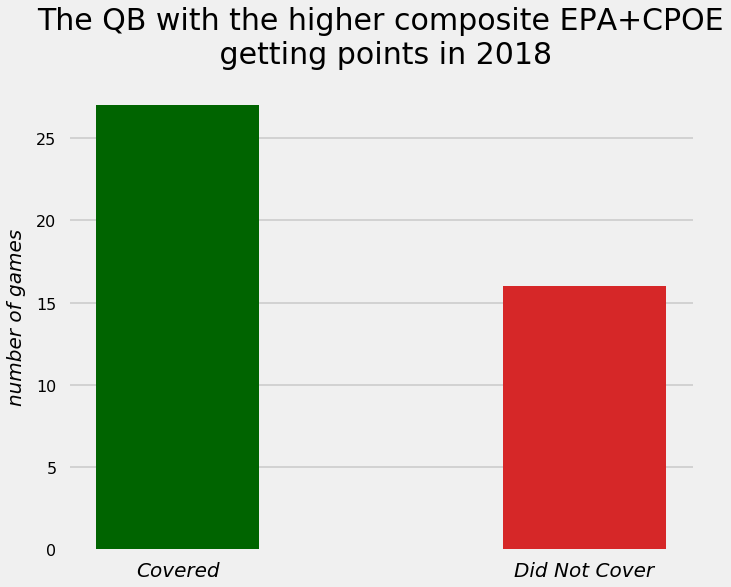

In [569]:
plt.style.use(['fivethirtyeight']) #making my graphs look purd..ier
plt.style.use(['seaborn-poster'])
plt.figure(figsize = (10, 8))#figsize
colors = ('DARKGREEN', 'tab:red')#custom color palletes 
# using the value counts queries and labels in an easier to manipulate(for me) list 
outcome = ['Covered', 'Did Not Cover']
count = [27, 16]
plt.bar(outcome, count, color= colors, width =.4)#plotting
plt.title('The QB with the higher composite EPA+CPOE\n getting points in 2021', size = 30, pad = 20, loc = 'center')#title
#style tweaks
plt.ylabel("number of games", size = 20, labelpad = 10, style = 'italic')
plt.xticks(style = 'italic', size = 20)
plt.grid(axis = 'x')

In [571]:
condensed.to_csv("better_qb_2021.csv", index = False)